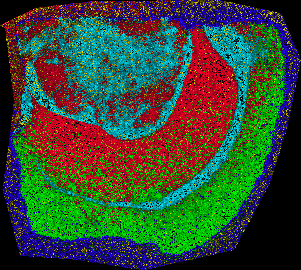

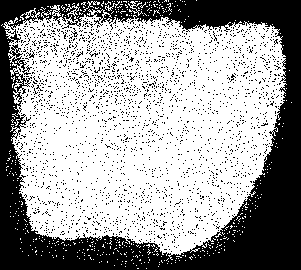

(51180, 701)


In [72]:
import numpy as np
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from visualizations import get_colors, show_factorization_on_image

img = np.load("D:\\maldi\\0.npy")
H = np.load("0_h.npy")
W = np.load("0_w.npy")
img = img[:, :, 300 : ]
orig = img.copy()
model = joblib.load("kmeans.joblib")
centers = model.cluster_centers_
order = []
diffs = []

for i in range(len(H)):
    sim = cosine_similarity(H[i, :][None, :], centers)[0, :]
    diffs.append(sim.max())
    order.append(sim.argmax())

NUM_COMPONENTS = 5
explanations = W.transpose().reshape(NUM_COMPONENTS, orig.shape[0], orig.shape[1])
explanations = explanations / np.percentile(explanations, 99, axis=(1, 2))[:, None, None]
#explanations[order.index(4)] = 0
#explanations[order.index(1)] = 0
colors = get_colors(NUM_COMPONENTS)

colors_ordered = [colors[i] for i in order] 

visualization = show_factorization_on_image(np.zeros(shape=((orig.shape[0], orig.shape[1], 3))),
                                            explanations,
                                            image_weight=0.0,
                                            colors=colors_ordered)

display(Image.fromarray(visualization))

mask = explanations.argmax(axis=0) + 1
mask[mask == order.index(4) + 1] = 0
mask[mask == order.index(1) + 1] = 0
mask[orig.max(axis=-1) == 0] = 0
#mask[order.index(3)] = 0
mask = np.uint8(mask > 0) * 255
display(Image.fromarray(mask))

img[mask == 0] = 0
training_data = img.reshape(-1, 701)
training_data = training_data[training_data.max(axis=-1) > 0]
training_data = training_data / (1e-6 + np.median(training_data, axis=-1)[:, None])

print(training_data.shape)

In [154]:
from umap.parametric_umap import ParametricUMAP
embedder = ParametricUMAP()
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=701),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
])

trans = ParametricUMAP(encoder=encoder, n_components=1, n_neighbors=50, n_training_epochs=1, dims=(701,)).fit(training_data)
#trans = umap.UMAP(n_components=3, n_neighbors=50, random_state=42).fit(img)
print(trans)

#joblib.dump(trans, "umap.joblib")
trans.save("parametric_umap3.obj")



Epoch 1/10
11150/11150 [==============================] - 724s 65ms/step - loss: 0.2809
Epoch 2/10
11150/11150 [==============================] - 799s 72ms/step - loss: 0.2780
Epoch 3/10
11150/11150 [==============================] - 613s 55ms/step - loss: 0.2774
Epoch 4/10
11150/11150 [==============================] - 614s 55ms/step - loss: 0.2770
Epoch 5/10
11150/11150 [==============================] - 833s 75ms/step - loss: 0.2768
Epoch 6/10
11150/11150 [==============================] - 613s 55ms/step - loss: 0.2768
Epoch 7/10
11150/11150 [==============================] - 611s 55ms/step - loss: 0.2767
Epoch 8/10
11150/11150 [==============================] - 629s 56ms/step - loss: 0.2766
Epoch 9/10
11150/11150 [==============================] - 816s 73ms/step - loss: 0.2766
Epoch 10/10
11150/11150 [==============================] - 866s 78ms/step - loss: 0.2765
ParametricUMAP(batch_size=1000, dims=(701,), encoder=<keras.src.engine.sequential.Sequential object at 0x000001FA871675

INFO:tensorflow:Assets written to: parametric_umap3.obj\encoder\assets


INFO:tensorflow:Assets written to: parametric_umap3.obj\encoder\assets


Keras encoder model saved to parametric_umap3.obj\encoder
INFO:tensorflow:Assets written to: parametric_umap3.obj\parametric_model\assets


INFO:tensorflow:Assets written to: parametric_umap3.obj\parametric_model\assets


Keras full model saved to parametric_umap3.obj\parametric_model


OSError: [Errno 28] No space left on device

Pickle of ParametricUMAP model loaded from parametric_umap3.obj\model.pkl


Keras encoder model loaded from parametric_umap3.obj\encoder
Keras full model loaded from parametric_umap3.obj\parametric_model
low -9.158759155273437 high 17.15931625366211
0.0 1.0
0.0 0.5013913
0.0 1.0


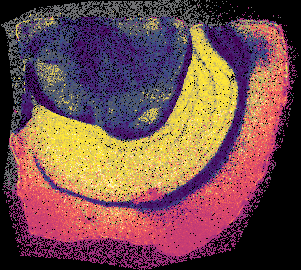

low -9.009044542312623 high 16.17668846130371
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


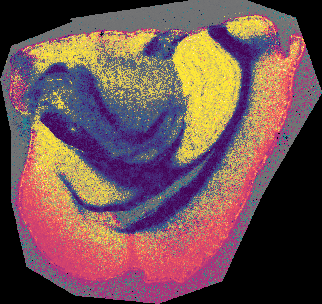

low -8.443749694824218 high 13.787647094726566
0.0 1.0
0.0 0.6496841
0.0 1.0


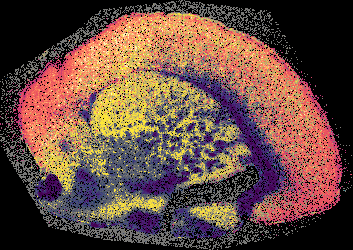

low -8.616074542999268 high 12.45517082214355
0.0 1.0
0.0 0.63487154
0.0 1.0


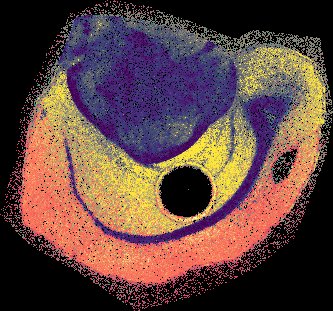

In [303]:
from PIL import Image
import cv2
import joblib
import numpy as np
from umap.parametric_umap import load_ParametricUMAP
import cmapy

def normalize_image_grayscale(grayscale):
    a = grayscale.copy()
    low = np.percentile(a[:], 1)
    a = (a - low) 
    a[a < 0] = 0
    high = np.percentile(a[:], 98)
    a = a / high
    a[a < 0] = 0
    a [ a > 1 ] = 1

    print("low", low, "high", high)
    
    return a

def normalize_image(img):
    a = img.copy()
    # a[:, :, 0] = a[:, :, 0] - np.percentile(a[:, :, 0], 1)
    # a[:, :, 0] = a[:, :, 0] / np.percentile(a[:, :, 0], 99)
    # a[:, :, 1] = a[:, :, 1] - np.percentile(a[:, :, 1], 1)
    # a[:, :, 1] = a[:, :, 1] / np.percentile(a[:, :, 1], 99)
    # a[:, :, 2] = a[:, :, 2] - np.percentile(a[:, :, 2], 1)
    # a[:, :, 2] = a[:, :, 2] / np.percentile(a[:, :, 2], 99)

    a[:, :, 0] = a[:, :, 0] - np.percentile(a[:, :, 0], 3)
    a[:, :, 0] = a[:, :, 0] / np.percentile(a[:, :, 0], 97)
    a[:, :, 1] = a[:, :, 1] - np.percentile(a[:, :, 1], 3)
    a[:, :, 1] = a[:, :, 1] / np.percentile(a[:, :, 1], 97)
    a[:, :, 2] = a[:, :, 2] - np.percentile(a[:, :, 2], 3)
    a[:, :, 2] = a[:, :, 2] / np.percentile(a[:, :, 2], 97)
    
    
    a[a < 0] = 0
    a [ a > 1 ] = 1
    return a

def image_histogram_equalization(image, mask, number_bins=256):
    # from http://www.janeriksolem.net/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image[mask > 0].flatten(), number_bins, density=True)
    
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)


trans = load_ParametricUMAP("parametric_umap3.obj")


for region in [0, 1, 2, 3]:
    order = []
    diffs = []

    img = np.load(f"D:\\maldi\\{region}.npy")
    img = img[:, :, 300 : ]
    orig = img.copy()
    img = img / (1e-6 + np.median(img, axis= -1)[:, :, None])

    H = np.load("0_h.npy")
    W = np.load("0_w.npy")
    
    W, H = np.load(f"{region}_W.npy"), np.load(f"{region}_h.npy")
    for i in range(len(H)):
        sim = cosine_similarity(H[i, :][None, :], centers)[0, :]
        diffs.append(sim.max())
        order.append(sim.argmax())

    NUM_COMPONENTS = 5
    explanations = W.transpose().reshape(NUM_COMPONENTS, orig.shape[0], orig.shape[1]) 
    explanations = explanations / np.percentile(explanations, 99, axis=(0, 1, 2))
    explanations[[i for i in range(len(order)) if order[i] == 4]] = 0
    #explanations[[i for i in range(len(order)) if order[i] == 1]] = 0
    
    transformed = trans.transform(img.reshape(-1, 701))
    transformed = transformed.reshape((img.shape[0], img.shape[1]))

    # print("before", np.percentile(transformed[:], 0.1),
    #       np.percentile(transformed[:], 1),
    #       np.percentile(transformed[:], 10),
    #       np.percentile(transformed[:], 50),
    #       np.percentile(transformed[:], 99))

    transformed = normalize_image_grayscale(transformed)

    # print("after", np.percentile(transformed[:], 0.1),
    #       np.percentile(transformed[:], 1),
    #       np.percentile(transformed[:], 10),
    #       np.percentile(transformed[:], 50),
    #       np.percentile(transformed[:], 99))
    
    explanations = explanations.argmax(axis=0)

    
    #a[explanations == order.index(1)] = 0
    
    
    result = []

    
    
    #colors_maps = ["hsv", "Pastel1", "Paired", "tab10",  "gist_rainbow"]
    #colors_maps = ["hsv", "jet", "viridis", "twilight"]
    colors_maps = ["cividis", "cividis", "magma", "viridis"]
    for index, value in enumerate(np.unique(explanations)):
        if order[value] in [0, 2, 3]:
            mask = np.uint8(explanations == value) * 255
            mask[orig.max(axis=-1) == 0] = 0
        
            masked_region = transformed.copy()
            mask[orig.max(axis=-1) == 0] = 0
            masked_region[mask == 0] = 0

            num_bins = 255
            #masked_region = image_histogram_equalization(masked_region, mask, num_bins) / (num_bins - 1)
            #masked_region = normalize_image_grayscale(masked_region)
            print(masked_region.min(), masked_region.max())
            
        
            
            masked_region_gray = np.uint8(masked_region * 255)
            masked_region = cv2.applyColorMap(masked_region_gray, cmapy.cmap(colors_maps[order[value]]))
            masked_region = masked_region[:, :, ::-1]
            masked_region[mask == 0] = 0
            
            result.append(masked_region)
            #display(Image.fromarray(masked_region))
    result = np.array(result)
    result = result.max(axis=0)

    #result = np.uint8(255 * a)
    
    result[np.array(orig.max(axis=-1) == 0)] = 0
    display(Image.fromarray(np.uint8(result)))

In [152]:
orig.shape

(270, 301, 701)

In [155]:
trans.save("parametric_umap3.obj")

INFO:tensorflow:Assets written to: parametric_umap3.obj\encoder\assets


INFO:tensorflow:Assets written to: parametric_umap3.obj\encoder\assets


Keras encoder model saved to parametric_umap3.obj\encoder
INFO:tensorflow:Assets written to: parametric_umap3.obj\parametric_model\assets


INFO:tensorflow:Assets written to: parametric_umap3.obj\parametric_model\assets


Keras full model saved to parametric_umap3.obj\parametric_model
Pickle of ParametricUMAP model saved to parametric_umap3.obj\model.pkl
